In [1]:
import pandas as pd
import numpy as np
import re
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data
filepath = '~/Documents/DataScience Notebooks/csv/1mio-clean_new.csv'
df = pd.read_csv(filepath,usecols=[3,5])
#drop unknown type
df = df.dropna()
#drop duplicates
df = df.drop_duplicates()
#map to binary classes
df['b_type'] = df['type'].apply(lambda x: 'FAKE' if x in ['fake','satire','bias','conspiracy','junksci'] else 'REAL')

In [3]:
#Function for queries with database
def execQuery(query,*printOption):
    try:
        connection = psycopg2.connect(user = "postgres",
                                      password = "1234",
                                      host = "localhost",
                                      port = "5432",
                                      database = "FakeNews")
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL:", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            if not printOption:
                print("Executed query and closed connection.")

## Number of articles

In [4]:
print(f"number of articles: {len(df)}")

number of articles: 586902


## Distribution of types 

,quantity,percent
political,203020,34.591806
fake,110046,18.750319
bias,93109,15.864488
conspiracy,57463,9.790902
rumor,44097,7.513520
unreliable,32512,5.539596
clickbait,19328,3.293224
junksci,11478,1.955693
satire,7514,1.280282
reliable,5222,0.889757


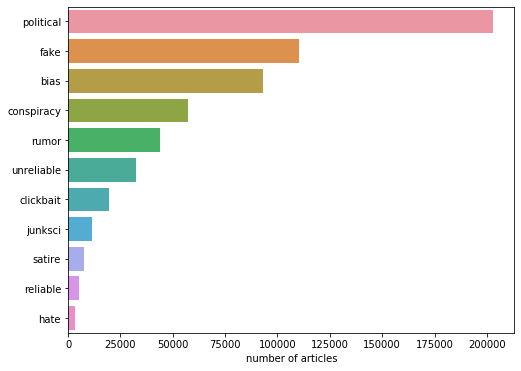

In [5]:
# distribution of types without null
x = df.type.value_counts()
plt.figure(figsize=(8,6))
sns.barplot(x,x.index)
plt.gca().set_xlabel('number of articles')
pd.DataFrame({'quantity':x,'percent':x/len(df)*100})

## Distribution of binary classes

,quantity,percent
REAL,307292,52.358315
FAKE,279610,47.641685


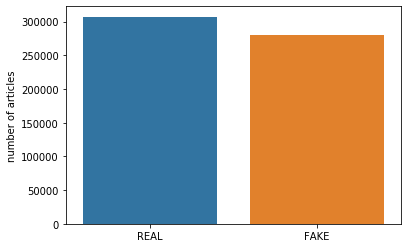

In [6]:
# distribution of binary type
x = df.b_type.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('number of articles')
pd.DataFrame({'quantity':x,'percent':x/len(df)*100})

## Looking at all authors who have written for multiple domains of different types, what are the most common combinations of these types? 

In [7]:
#defining SQL query
query4_2 = """
SELECT array_agg(distinct d.type)
FROM authors aus
    INNER JOIN article a USING (article_id)
    INNER JOIN domain d USING (domain_id)
GROUP BY aus.author_id
HAVING COUNT(DISTINCT d.type)>1;
"""
#executing query
res4_2 = execQuery(query4_2)

Executed query and closed connection.


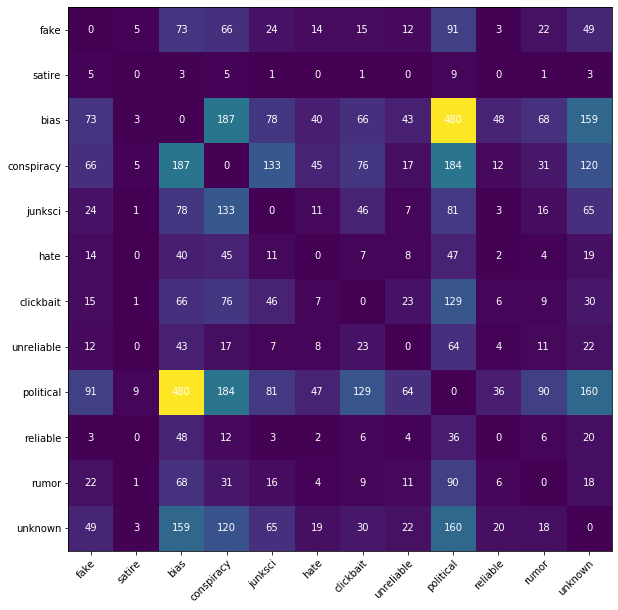

In [8]:
#creating visualization
if res4_2:
    #initializing
    types = ['fake','satire','bias','conspiracy','junksci','hate','clickbait','unreliable',
             'political','reliable','rumor',None]
    d = {(a,b):0 for a in types for b in types}
    #counting pairs of types
    for tup in res4_2:
        lst = tup[0]
        for i in range(len(lst)):
            for j in range(len(lst)):
                if lst[i] != lst[j]:
                    d[lst[i],lst[j]] = d[lst[i],lst[j]] + 1
                    
    #creating 11x11 numpy array of counted pairs                
    num = np.array([[d[a,b] for b in types] for a in types])
    
    #creating heatmap
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(num)

    ax.set_xticks(np.arange(len(types)))
    ax.set_yticks(np.arange(len(types)))
    ax.set_ylim(len(types)-0.5, -0.5) #Manual 'bug-workaround' for matplot: Some systems cut off a bit of the heatmap. See: https://github.com/matplotlib/matplotlib/issues/14751
    
    ax.set_xticklabels(types[:-1]+['unknown'])
    ax.set_yticklabels(types[:-1]+['unknown'])

    # Rotate the tick labels of x-axis and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(types)):
        for j in range(len(types)):
            text = ax.text(j, i, num[i, j], ha="center", va="center", color="w")
    
    plt.show()

The heatmap indicates that 'political/bias' is the most common combination of different domain types for an author to write for.
Other common combinations: 'conspiracy/bias', 'political/conspiracy', and 'unknown/bias'.

## Looking at the domanin extensions ('com','org' etc.) present in the domains of the dataset, which domain types do these domain extensions appear in?

In [9]:
# The list of the different possible types in the FakeNewsCorpus data set, that is not NULL/None.
types = ['rumor','hate','unreliable','conspiracy','clickbait','satire','fake','reliable','bias','political','junksci',None]

# The most common domain exstensions found in the FakeNewsCorpus data set.
domExtLst = ["com", "org"]
domExtLst2 = domExtLst + ["other"]

In [10]:
#defing pieces of queries
piece1 = """SELECT type, count(*)
            FROM domain
            WHERE value LIKE '%."""
piece2 = """ GROUP BY type"""
piece3 = """SELECT type, count(*)
       FROM domain
       WHERE NOT ("""
piece4 = """value like '%."""
piece5 = """SELECT count(*) FROM domain WHERE value LIKE '%."""
piece6 = """SELECT count(*) FROM domain WHERE NOT("""

#initializing dictionary for value storage
d = {(a,b):0 for a in types for b in domExtLst2}
nr_domains_with_ext = {}

#iterating over domain extensions
for idx,domExt in enumerate(domExtLst):
    #assembling and executing query for every domain extension
    res4_3a = execQuery(piece1+domExt+"'"+piece2,"No print") #type, count
    res4_3b = execQuery(piece5+domExt+"'","No print") #count
    
    dv = 1
    #extracting count value from query output
    if res4_3b: dv = res4_3b[0][0]
    nr_domains_with_ext[domExt] = dv
    
    #calculating and storing percentage of type for the given domain extension
    if res4_3a:
        for a,b in res4_3a:
            d[a,domExt] = b/dv
    if idx == 0:
        piece3 += piece4+domExt+"'"
        piece6 += piece4+domExt+"'"
    else:
        piece3 += " OR "+piece4+domExt+"'"
        piece6 += " OR "+piece4+domExt+"'"
        
#listing, by type grouping, the number of domain extensions not in domExtLst
query4_3c = piece3 + """) GROUP BY type"""
#count the domain extensions in query4_3c
query4_3d = piece6 + ")"

#executing queries
res4_3c = execQuery(query4_3c,"No print")
res4_3d = execQuery(query4_3d,"No print")

#which gives the outputs:
print('query4_3c:')
print(res4_3c)
print('query4_3d:')
print(res4_3d)

query4_3c:
[('satire', 7), ('hate', 1), (None, 6), ('bias', 4), ('conspiracy', 7), ('junksci', 1), ('fake', 3), ('unreliable', 4), ('rumor', 1)]
query4_3d:
[(34,)]


In [11]:
dv = 1
#extracting count value from query output
if res4_3d: dv = res4_3d[0][0]
nr_domains_with_ext['other'] = dv

#adding domain extensions of category 'other' to dictionary
if res4_3c:
    for a,b in res4_3c:
        d[a,'other'] = b/dv
#converting to numpy array
num = np.array([[d[a,b] for a in types] for b in domExtLst2])
num = np.around(num, decimals=3)

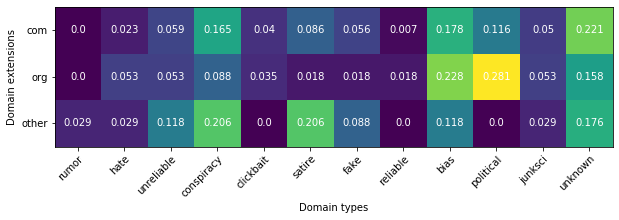

In [12]:
#creating heatmap
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(num)

ax.set_xticks(np.arange(len(types)))
ax.set_yticks(np.arange(len(domExtLst2)))

ax.set_xticklabels(types[:-1]+['unknown'])
ax.set_yticklabels(domExtLst2)
ax.set_ylim(len(domExtLst2)-0.5, -0.5)

ax.set_xlabel('Domain types')
ax.set_ylabel('Domain extensions')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(domExtLst2)):
    for j in range(len(types)):
        text = ax.text(j, i, num[i, j],
                       ha="center", va="center", color="w")

plt.show()

The heatmap shows the probability of a domain for a certain type given it has a specific domain extension.
The most frequent domain extension are by far 'com' while the rest are less frequent. This is shown here:

In [13]:
nr_domains_with_ext

{'com': 303, 'org': 57, 'other': 34}

The domains with extension 'com' or 'org' are more likely to be of types bias, political or unknown, and for 'com' it can also be of type conspiracy.
The not so common domain extensions are more likely to be of types unreliable, conspiracy, satire, bias and unknown, and not political unlike the 'com' and 'org'.
As shown bellow, it should also be noted that the most common types of domains are unknown, bias, conspiracy and political, therefore they stand out more in the heatmap.

In [14]:
#number of domains grouped by domain types
query4_3e = """select type, count(*)
           from domain
           group by type"""
execQuery(query4_3e,"No print")

[('clickbait', 14),
 ('unreliable', 25),
 ('rumor', 1),
 ('reliable', 3),
 ('political', 51),
 ('satire', 34),
 ('hate', 11),
 (None, 82),
 ('bias', 71),
 ('junksci', 19),
 ('conspiracy', 62),
 ('fake', 21)]

This investigation of the domain extensions being of the different domain types (among other things) illustrates non-uniformly distributed Domain extensions, domain types and the importance knowing the domain-extensions when guessing which domain type it is. 
